In [ ]:
!pip install transformers datasets torchinfo

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

import torch

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

# Download and EDA data

In [ ]:
df_ = pd.read_csv('/content/drive/MyDrive/udemy_course/data/sentiment_classification/AirlineTweets.csv')
df_.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [ ]:
df = df_[["airline_sentiment", "text"]].copy()
df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


<AxesSubplot:>

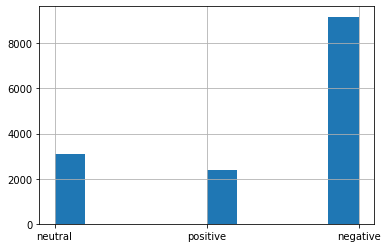

In [ ]:
df['airline_sentiment'].hist()

the dataset is out of balance. It is biased towards the negative class.

In [ ]:
#Convert label from string to int
target_map = {'positive':1, 'negative':0, 'neutral':2}
df['target'] = df['airline_sentiment'].map(target_map)

In [ ]:
#Take the required columns and rename it acordingly
df2 = df[['text', 'target']]
df2.columns = ['sentence', 'labels']
df2.to_csv('data.csv', index=None)

In [ ]:
!head data.csv

sentence,label
@VirginAmerica What @dhepburn said.,2
@VirginAmerica plus you've added commercials to the experience... tacky.,1
@VirginAmerica I didn't today... Must mean I need to take another trip!,2
"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",0
@VirginAmerica and it's a really big bad thing about it,0
"@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.
it's really the only bad thing about flying VA",0
"@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)",1
"@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP",2


In [ ]:
from datasets import load_dataset

#Create dataset object from csv file
raw_dataset = load_dataset('csv', data_files='data.csv')
raw_dataset

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-266da7a12ac7888b/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 14640
    })
})

In [ ]:
# Split train and test dataset
split_ds = raw_dataset['train'].train_test_split(test_size=0.2, seed=42)
split_ds

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 11712
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 2928
    })
})

# Tokenizer

In [ ]:
#checkpoint of model
checkpoint = 'distilbert-base-cased'

In [ ]:
from transformers import AutoTokenizer

#Create a tokenizer object from checkpoint
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [ ]:
#define a function for tokenize sentence
def tokenize_fn(batch):
  return tokenizer(batch['sentence'], truncation=True)

In [ ]:
#Apply for train and test dataset
tokenized_ds = split_ds.map(tokenize_fn, batched=True)

Map:   0%|          | 0/11712 [00:00<?, ? examples/s]

Map:   0%|          | 0/2928 [00:00<?, ? examples/s]

# Download pretrained model and fine-tune

In [ ]:
from transformers import AutoModelForSequenceClassification
#Define config for label
label2id = {'negative':0, 'positive':1, 'neutral':2}
id2label = {v:k for k,v in label2id.items()}
#Download model from checkpoint
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, id2label=id2label, label2id=label2id)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/9d7568e4b20ed5db15ee30e99c7219bde9990762/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-cased",
  "activation": "gelu",
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "negative",
    "1": "positive",
    "2": "neutral"
  },
  "initializer_range": 0.02,
  "label2id": {
    "negative": 0,
    "neutral": 2,
    "positive": 1
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1",
  "vocab_size": 28996
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/9d7568e4b20ed5db15ee30e

In [ ]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [ ]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                                  Param #
DistilBertForSequenceClassification                     --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              22,268,928
│    │    └─Embedding: 3-2                              393,216
│    │    └─LayerNorm: 3-3                              1,536
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             42,527,232
├─Linear: 1-2                                           590,592
├─Linear: 1-3                                           2,307
├─Dropout: 1-4                                          --
Total params: 65,783,811
Trainable params: 65,783,811
Non-trainable params: 0

In [ ]:
#Create training arguments object
from transformers import TrainingArguments

save_checkpoint = '/content/drive/MyDrive/udemy_course/saved_model/sentiment_classification/checkpoint/'
training_args = TrainingArguments(
    output_dir=save_checkpoint, #checpoint save path
    evaluation_strategy='epoch', #model will be evaluated at the end of each epoch
    save_strategy='epoch', #model will be saved at the end of each epoch
    num_train_epochs=3,
    per_device_train_batch_size=16, #Number of samples processed at the same time on one device during training
    per_device_eval_batch_size=32, #Number of samples processed at the same time on one device when evaluating 
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
#Define compute metrics function
def compute_metrics(logits_and_labels):
  logits, labels = logits_and_labels
  predictions = np.argmax(logits, axis=-1)
  acc = accuracy_score(labels, predictions)
  f1 = f1_score(labels, predictions, average='macro')
  return {'accuracy': acc, 'f1': f1}

In [ ]:
#Test compute_metrics function
compute_metrics(([[0.1, 0.2, 0.8],
                  [0.3, 0.4, 0.3]], [1,1]))

{'accuracy': 0.5, 'f1': 0.3333333333333333}

In [ ]:
from transformers import Trainer

#Create a trainer object
trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_ds['train'],
    eval_dataset=tokenized_ds['test'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence. If sentence are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 11712
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 2196
  Number of trainable parameters = 65783811


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.538300,0.445688,0.837090,0.780647
2,0.366500,0.475325,0.840847,0.786431
3,0.153300,0.638254,0.839481,0.787314


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence. If sentence are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2928
  Batch size = 32
Saving model checkpoint to /content/drive/MyDrive/udemy_course/saved_model/sentiment_classification/checkpoint/checkpoint-732
Configuration saved in /content/drive/MyDrive/udemy_course/saved_model/sentiment_classification/checkpoint/checkpoint-732/config.json
Model weights saved in /content/drive/MyDrive/udemy_course/saved_model/sentiment_classification/checkpoint/checkpoint-732/pytorch_model.bin
tokenizer config file saved in /content/drive/MyDrive/udemy_course/saved_model/sentiment_classification/checkpoint/checkpoint-732/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/udemy_course/saved_model/sentiment_classificati

TrainOutput(global_step=2196, training_loss=0.3189020625880507, metrics={'train_runtime': 216.1191, 'train_samples_per_second': 162.577, 'train_steps_per_second': 10.161, 'total_flos': 443959985031840.0, 'train_loss': 0.3189020625880507, 'epoch': 3.0})

model is being overfitting 

# Using model with pipline

In [ ]:
!ls /content/drive/MyDrive/udemy_course/saved_model/sentiment_classification/checkpoint

checkpoint-1464  checkpoint-2196  checkpoint-732  runs


In [ ]:
from transformers import pipeline

#Load pipeline model from saved_path
save_model = pipeline('text-classification',
                      model=save_checkpoint+'checkpoint-2196',
                      device=0)

loading configuration file /content/drive/MyDrive/udemy_course/saved_model/sentiment_classification/checkpoint/checkpoint-2196/config.json
Model config DistilBertConfig {
  "_name_or_path": "/content/drive/MyDrive/udemy_course/saved_model/sentiment_classification/checkpoint/checkpoint-2196",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "negative",
    "1": "positive",
    "2": "neutral"
  },
  "initializer_range": 0.02,
  "label2id": {
    "negative": 0,
    "neutral": 2,
    "positive": 1
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_ver

In [ ]:
split_ds['test']

Dataset({
    features: ['sentence', 'label'],
    num_rows: 2928
})

# Predict and evalute on test data

In [ ]:
test_pred = save_model(split_ds['test']['sentence'])
test_pred

In [ ]:
#Convert string lables to int labels
test_pred = [label2id[d['label']] for d in test_pred]

In [ ]:
print("acc:", accuracy_score(split_ds['test']['label'], test_pred))

acc: 0.8394808743169399


In [ ]:
print('f1:', f1_score(split_ds['test']['label'], test_pred, average='macro'))

f1: 0.7873135726469012


In [ ]:
def plot_cm(cm):
  plt.figure(figsize=(9,6))
  df_cm = pd.DataFrame(cm, index=label2id.keys(), columns=label2id.keys())
  ax = sn.heatmap(df_cm, annot=True, fmt='g')
  ax.set_xlabel("Predicted")
  ax.set_ylabel("Target")

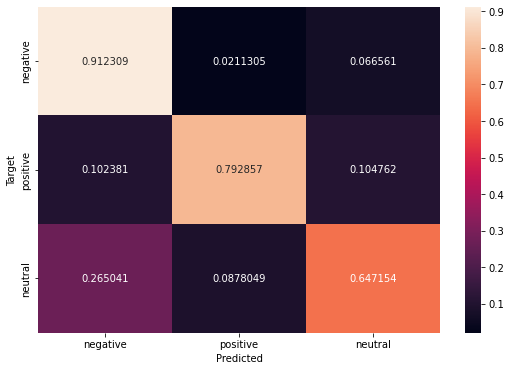

In [ ]:
cm = confusion_matrix(split_ds['test']['label'], test_pred, normalize='true')
plot_cm(cm)

- The model predicts well for the negative class, not good for the neutral class. 
- When predicting the neutral class, the confusion that occurs with the negative class is quite a lot. 
- When predicting the positive class, mistakes occur equally in the other two classes. 
- These things happen because the data is out of balance. There is more data for the negative layer.